The purpose of this notebook is to explore and document methods for image processing to retrieve content of the best quality that is possible. Image processing is done with `cv2` library, whereas content extraction is done with `pytesseract` (`Tesseract` Python wrapper).

`Tesseract` is an open source text recognition (OCR) engine ([Tesseract User Manual](https://github.com/tesseract-ocr/tessdoc)).

#### Tesseract version in use

In [1]:
!tesseract -v

tesseract v5.2.0.20220712
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.3) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.5.0 zlib/1.2.11 liblzma/5.2.3 bz2lib/1.0.6 liblz4/1.7.5 libzstd/1.4.5
 Found libcurl/7.77.0-DEV Schannel zlib/1.2.11 zstd/1.4.5 libidn2/2.0.4 nghttp2/1.31.0


#### Notebook settings

In [2]:
%matplotlib inline

## Import modules

In [3]:
import itertools
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytesseract

In [4]:
# Change the working directory to root
os.chdir('./..')

In [5]:
from scripts.content_detector import process_image

# Turn off log messages
process_image.LOG = False

## Raw images

`Tessetract` documentation suggests using a resolution of at least 300 dpi.
Hence, only 300 and 600 dpi images will be evaluated.

Also a [study](https://groups.google.com/g/tesseract-ocr/c/Wdh_JJwnw94/m/24JHDYQbBQAJ) was conducted, which has shown that the height of capital letters is of great importance.
It was noticed that the best accuracy is achieved when the height of capital letter is around 30 to 33 pixels.

The height of a capital letter in 300 dpi reference image is around 32 pixels, so it expected to provide the best output.

In [6]:
raw_img_folderpath = 'images/receipts'
raw_img_filenames = os.listdir('images/receipts')
raw_img_filenames

['Paragon_2022-08-11_081131_300dpi.jpg',
 'Paragon_2022-08-11_081332_600dpi.jpg']

In [7]:
# Read raw images
raw_imgs = {
    '300 dpi': cv.imread(os.path.join(raw_img_folderpath, raw_img_filenames[0])),
    '600 dpi': cv.imread(os.path.join(raw_img_folderpath, raw_img_filenames[1])),
}

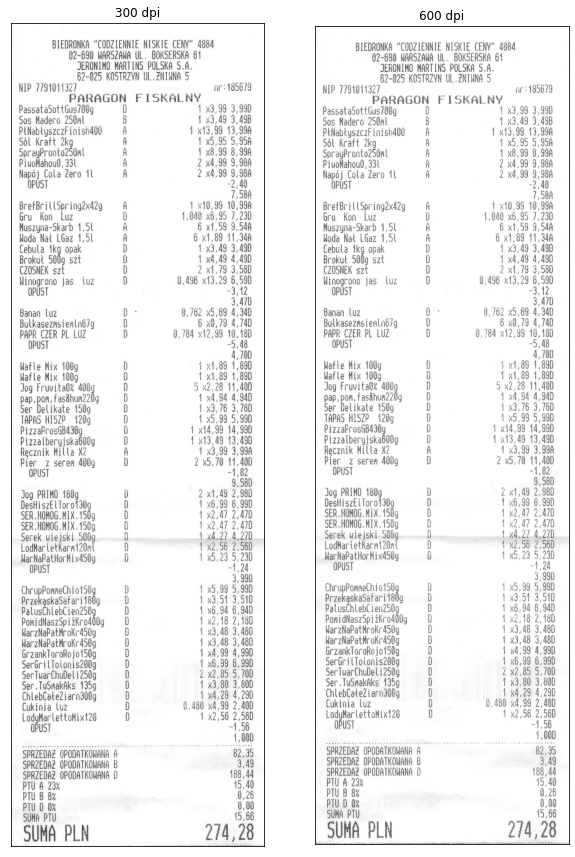

In [8]:
# Plot raw images
fig, ax = plt.subplots(1, 2,
                       figsize=(10, 50),
                       subplot_kw={'xticks': [], 'yticks': []})

ax[0].imshow(raw_imgs['300 dpi'])
ax[1].imshow(raw_imgs['600 dpi'])

ax[0].set_title('300 dpi')
ax[1].set_title('600 dpi');

### Image resolution impact

The impact of image resolution on OCR output quality will be checked.

In [9]:
def get_split_content(img):
    content = pytesseract.image_to_string(cv.cvtColor(img, cv.COLOR_BGR2RGB), config='--psm 4')
    
    return content.split('\n')

In [10]:
# Get the content from raw images
raw_imgs_content = {dpi: get_split_content(img) for dpi, img in raw_imgs.items()}

In [11]:
# Print the raw content
for line_300, line_600 in zip(*raw_imgs_content.values()):
    print(f'{line_300:<45} | {line_600:<45}')

BIEDRONKA “CODZIENNIE NISKIE CENY” 4884       | BIEDRONKA “CODZTENNTE NISKIE CENY” dead      
02-690 WARSZAWA UL, BOKSERSKA 64              | 02-690 WARSZAWA UL, BORSERSKA 64             
JERONIMO MARTINS POLSKA S.A.                  | JERONIMO MARTINS POLSKA 5.A.                 
62-025 KOSTRZYN UL. ZNIHNA 5                  | 62-025 KOSTRZYN UL.ZNIMNA 5                  
                                              |                                              
NIP 7794011327 wr 485679                      | NIP 7794041327 nr 185679                     
PARAGON FISKALNY                              | PARAGON FISKALNY                             
PassataSot thus 708g b { x3,99 3,990          | PassataSot thus /00g [ 1 x3,99 3,990         
Sos Madero 250ql 5 { x3,49 3,498              | Sos Madera 250nl b i «3,49 3,496             
PtNabtyszezFinishd00 = A 1 «13,99 13,998      | PlNabtyszezr inisndde A | ¥43,99 43,994      
Sol Kraft 2kg A 4 x5,95 5,95A                 | 56. Kraft zk

There's no clear indication which image resolution is better for content extraction.

Now, rows with different content will be compared.

In [12]:
# Read the reference file with content
with open('images/check/Paragon_text.txt', encoding='utf-8') as f:
    ref_content = f.read().split('\n')

In [13]:
diff_lines = []
accuracy = {'300 dpi': [], '600 dpi': []}

for line_ref, line_300, line_600 in zip(ref_content, *raw_imgs_content.values()):
    if line_300 != line_600:
        print(f'{line_ref:<40}|{line_300:<40}|{line_600:<40}')
        
        n_correct_300, n_correct_600 = 0, 0
        
        for char_ref, char_300, char_600 in zip(line_ref, line_300, line_600):
            if char_ref == char_300:
                n_correct_300 += 1
            if char_ref == char_600:
                n_correct_600 += 1
        
        diff_lines.append(line_ref)
        accuracy['300 dpi'].append(100 * n_correct_300 / len(line_ref))
        accuracy['600 dpi'].append(100 * n_correct_600 / len(line_ref))

BIEDRONKA “CODZIENNIE NISKIE CENY“ 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZTENNTE NISKIE CENY” dead 
02-690 WARSZAWA UL. BOKSERSKA 61        |02-690 WARSZAWA UL, BOKSERSKA 64        |02-690 WARSZAWA UL, BORSERSKA 64        
JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA 5.A.            
62-025 KOSTRZYN UL.ŻNIWNA 5             |62-025 KOSTRZYN UL. ZNIHNA 5            |62-025 KOSTRZYN UL.ZNIMNA 5             
NIP 7791011327 nr:185679                |NIP 7794011327 wr 485679                |NIP 7794041327 nr 185679                
PassataSottGus700g D 1 x3,99 3,99D      |PassataSot thus 708g b { x3,99 3,990    |PassataSot thus /00g [ 1 x3,99 3,990    
Sos Madero 250ml B 1 x3,49 3,49B        |Sos Madero 250ql 5 { x3,49 3,498        |Sos Madera 250nl b i «3,49 3,496        
PłNabłyszczFinish400 A 1 x13,99 13,99A  |PtNabtyszezFinishd00 = A 1 «13,99 13,998|PlNabtyszezr inisndde A | ¥43,99 43,994 
Sól Kraft 2kg A 

In [14]:
round(np.mean(accuracy['300 dpi']), 0)

66.0

In [15]:
round(np.mean(accuracy['600 dpi']), 0)

56.0

In [16]:
def get_accuracy(ref, other):
    """Return the accuracy of recognition for each line in the reference."""
    accuracy = []
    
    for line_ref, line_other in zip(ref, other):
        
        n_correct = 0
        
        for char_ref, char_other in zip(line_ref, line_other):
            if char_ref == char_other:
                n_correct += 1
        try:
            accuracy.append(100 * n_correct / len(line_ref))
        except ZeroDivisionError:
            accuracy.append(100)
        
    return round(np.mean(accuracy))

In [17]:
get_accuracy(ref_content, raw_imgs_content['300 dpi'])

68

In [18]:
get_accuracy(ref_content, raw_imgs_content['600 dpi'])

59

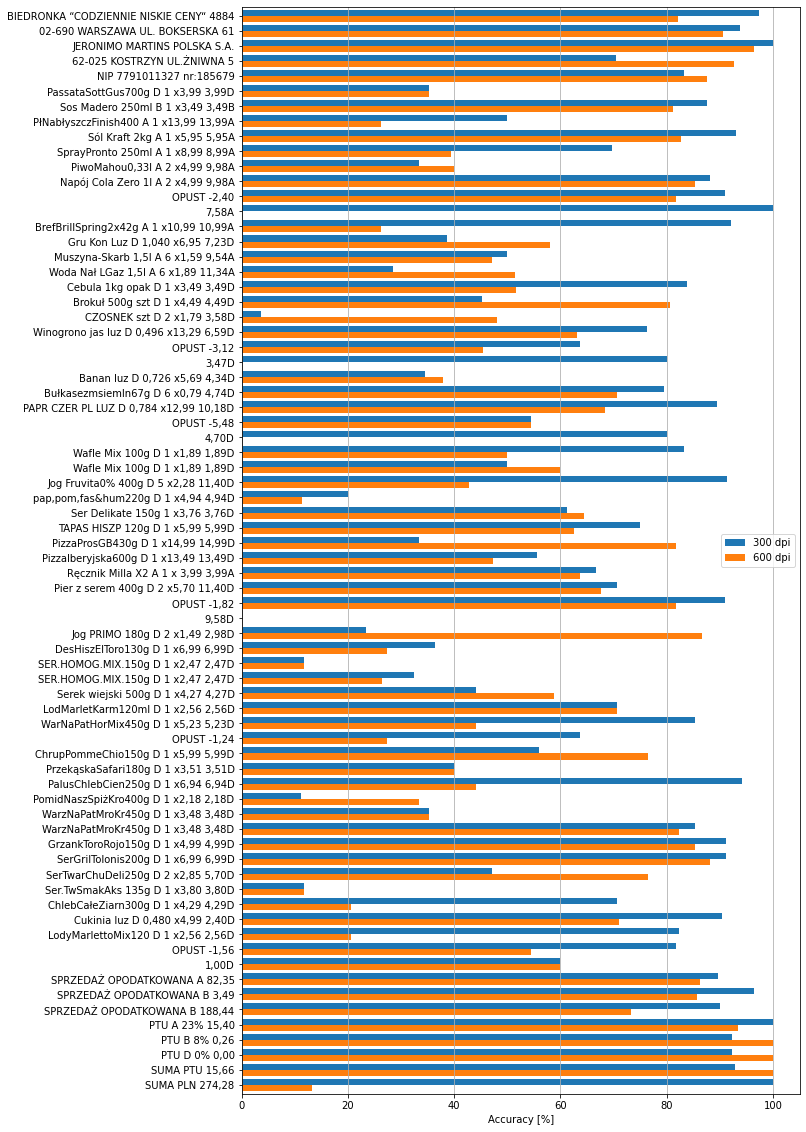

In [19]:
fig, ax = plt.subplots(figsize=(10, 20))

y_pos = np.arange(len(diff_lines))

ax.barh(y_pos - 0.2, accuracy['300 dpi'], 0.4, label='300 dpi')
ax.barh(y_pos + 0.2, accuracy['600 dpi'], 0.4, label='600 dpi')

ax.set_yticks(y_pos, labels=diff_lines)
ax.set_xlabel('Accuracy [%]')
ax.set_ylim([0.4 - 1, len(y_pos) - 0.4])

ax.legend()
ax.grid(axis='x')

ax.invert_yaxis();

300 dpi resolution seems to provide the best results and it will be used for further processing.

In [20]:
raw_img = raw_imgs['300 dpi']
raw_img_content = raw_imgs_content['300 dpi']

## Processed images

### Binarisation

Binarisation is a process of converting an arbitraty image that consists of black and white only. `Tesseract` does this internally, but the result might not be satisfying.

To simplify the evaluation, the reference image will be cropped.

In [21]:
raw_img_crop = raw_img[50:1485, 0:raw_img.shape[1]]

In [22]:
# Get content for the cropped reference image
raw_img_crop_content = get_split_content(raw_img_crop)

In [23]:
# Get cropped reference content
ref_content_crop = ref_content[:38]

#### Simple thresholding

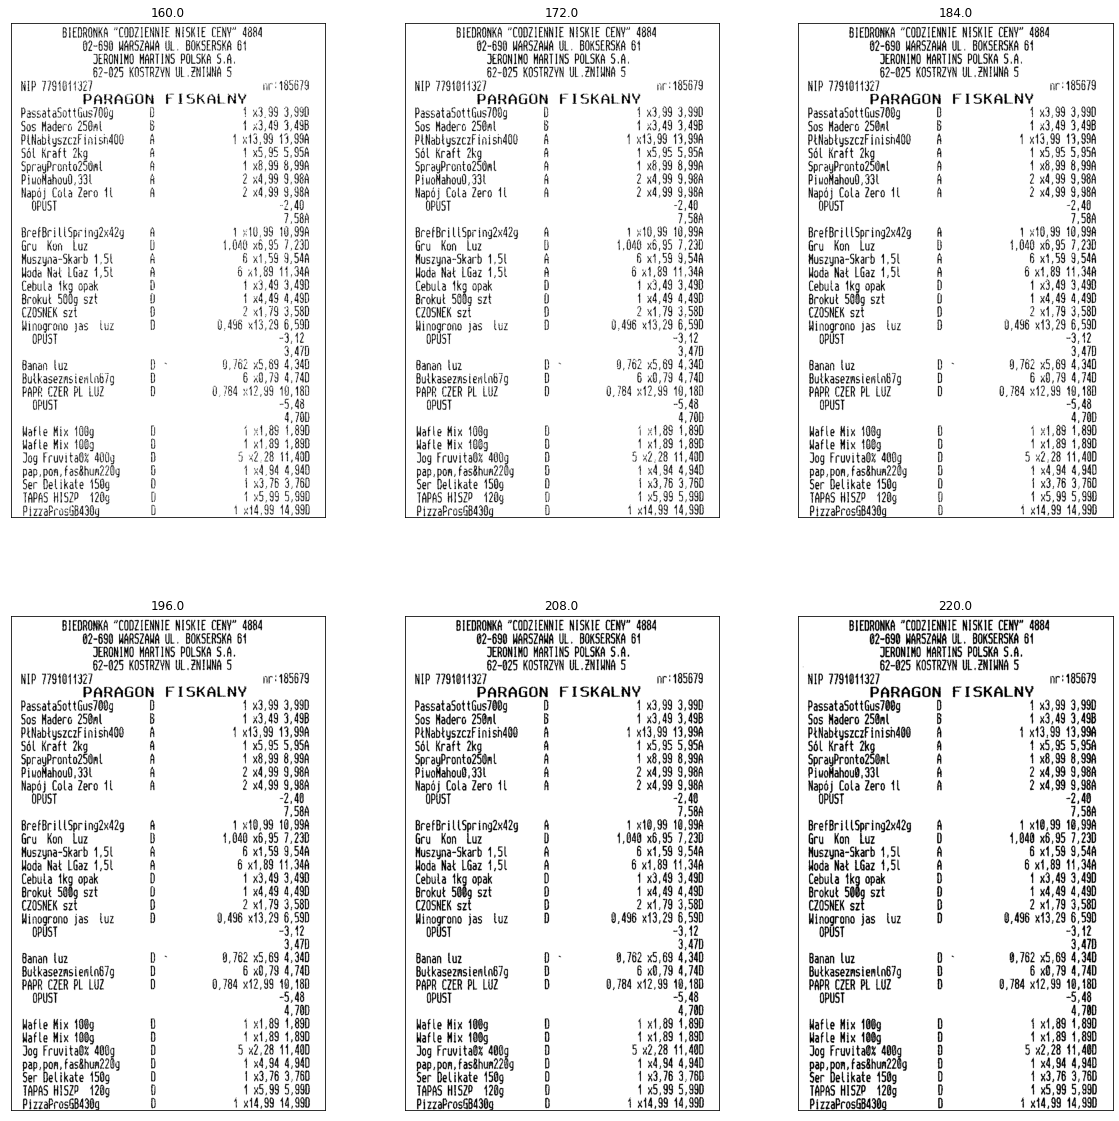

In [24]:
# Show binarised images wih different threshold values
fig, ax = plt.subplots(2, 3, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

thresholds = np.linspace(160, 220, 6).reshape(2, 3)
imgs_simple_thresh = {}

for i in range(2):
    for j in range(3):
        img = cv.threshold(raw_img_crop, thresholds[i][j], 255, cv.THRESH_BINARY)[1]
        imgs_simple_thresh[thresholds[i][j]] = img
        
        ax[i][j].imshow(img)
        ax[i][j].set_title(thresholds[i][j])

In [25]:
imgs_simple_thresh_content = {thresh: get_split_content(img) for thresh, img in imgs_simple_thresh.items()}

In [26]:
# Print the raw content
for line_1, line_2, line_3, *args in zip(*imgs_simple_thresh_content.values()):
    print(f'{line_1:<40}|{line_2:<40}|{line_3:<40}')

BIEDRONKA “CODZIENNIE NESKIE CENY” 4384 |BIEDRONKA “CODZIENNIE NESKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NESKIE CENY” 4884 
02-690 WARSZAWA UL. BOKSERSKA 61        |82-690 WARSZAWA UL. BOKSERSKA 64        |82-690 WARSZAWA UL. BOKSERSKA 64        
JERONIMO MARTINS POLSKA 5.4.            |JERONIMO MARTINS POLSKA 5.4.            |JERONIMG MARTINS POLSKA 5.8.            
62-025 KOSTRZYN UL. ZNINKA 5            |62-025 KOSTRZYN UL. ZNTHNA 5            |62-025 KOSTRZYN UL. ZNIMNA 5            
                                        |                                        |                                        
NIP 7784041327 wr 185679                |NIP 779401132? nr 4185079               |NIP 7794611327 nr 185679                
PARAGON FISKALNY                        |PARAGON FISKALNY                        |PARAGON FISKALNY                        
PassataSot tGus/Gy b 3,99 3,950         |PassataSot thus 7g i 4 «3,99 3,990      |PassataSot tGus/08q i { «3,99 3,990     
Sos Madero Z250a

In [27]:
# Print the raw content
for *args, line_1, line_2, line_3 in zip(*imgs_simple_thresh_content.values()):
    print(f'{line_1:<40}|{line_2:<40}|{line_3:<40}')

BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 
82-690 WARSZANA UL. BOKSERSKA 64        |02-690 WARSZANA UL. BO Bt               |02-690 WARSZAWA UL. BOSE RK 6           
JERONIMG MARTINS POLSKA 5.A.            |JERONIMO MARTINS POLSKA $               |JERONIMO MARTINS POLSKA 5               
62-025 KOSTRZYN UL. ZNINNA 5            |62-025 KOSTRZYN UL. ZNIMNA f            |62-025 KOSTRZYN UL. ZNIWNA $            
                                        |                                        |                                        
NIP 7794011327 nr 185679                |NIP 7794011327 nr? 185879               |NIP 7791041327 nr: 185679               
PARAGON FISKALNY                        |PARAGON FISKALNY                        |PARA AGON FISKALNY                      
Passat aSot tGus 700g B 4 x3,99 3,990   |PassataSot tGus 700g B 1 x3,99 3,990    |PassataSot thus 740g { 3, 99 3,990      
Sos Maderc 25@al

In [28]:
# Get accuracy for all thresholded images
accuracy = {}
for thresh, content in imgs_simple_thresh_content.items():
    accuracy[thresh] = get_accuracy(ref_content_crop, content)
accuracy['ori'] = get_accuracy(ref_content_crop, raw_img_crop_content)
    
accuracy

{160.0: 32, 172.0: 70, 184.0: 69, 196.0: 74, 208.0: 70, 220.0: 52, 'ori': 68}

In [29]:
# Compare reference, unprocessed and thresholded output
for line_ref, line_ori, line_thresh in zip(ref_content_crop, raw_img_crop_content, imgs_simple_thresh_content[196]):
    print(f'{line_ref:<40}|{line_ori:<40}|{line_thresh:<40}')

BIEDRONKA “CODZIENNIE NISKIE CENY“ 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 
02-690 WARSZAWA UL. BOKSERSKA 61        |02-690 WARSZAWA UL, BOKSERSKA 64        |82-690 WARSZANA UL. BOKSERSKA 64        
JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA S.A.            |JERONIMG MARTINS POLSKA 5.A.            
62-025 KOSTRZYN UL.ŻNIWNA 5             |62-025 KOSTRZYN UL. ZNIHNA 5            |62-025 KOSTRZYN UL. ZNINNA 5            
                                        |                                        |                                        
NIP 7791011327 nr:185679                |NIP 7794011327 wr} 185679               |NIP 7794011327 nr 185679                
PARAGON FISKALNY                        |PARAGON FISKALNY                        |PARAGON FISKALNY                        
PassataSottGus700g D 1 x3,99 3,99D      |PassataSot thus700g B { x3,99 3,990     |Passat aSot tGus 700g B 4 x3,99 3,990   
Sos Madero 250ml

Now a blurred image will be taken as a source to thresholding.

In [30]:
raw_img_crop_blur = cv.GaussianBlur(raw_img_crop, (3, 3), 0)

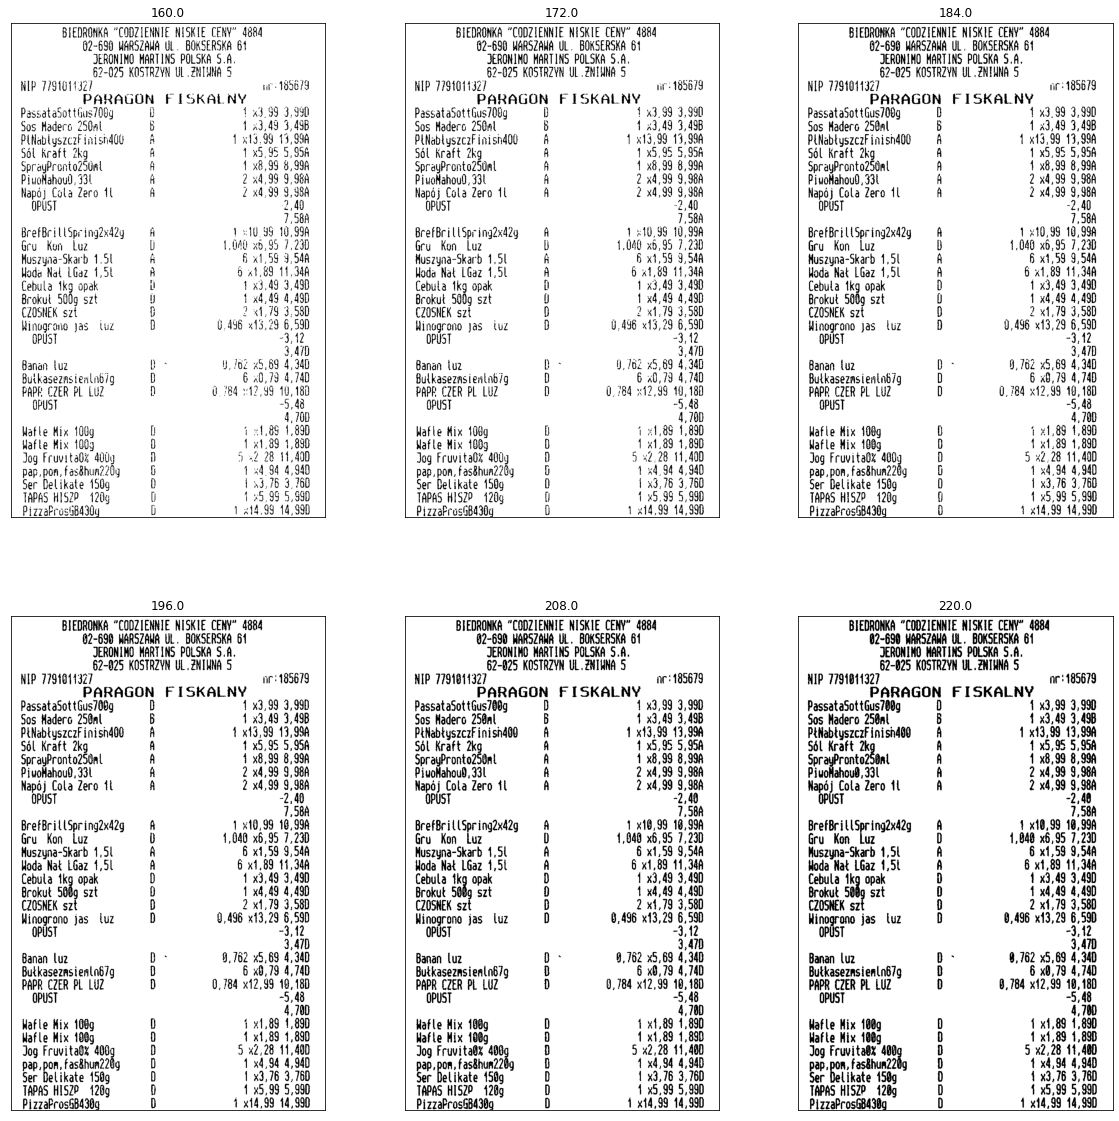

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

thresholds = np.linspace(160, 220, 6).reshape(2, 3)
imgs_simple_thresh_blur = {}

for i in range(2):
    for j in range(3):
        img = cv.threshold(raw_img_crop_blur, thresholds[i][j], 255, cv.THRESH_BINARY)[1]
        imgs_simple_thresh_blur[thresholds[i][j]] = img
        
        ax[i][j].imshow(img)
        ax[i][j].set_title(thresholds[i][j])

In [32]:
imgs_simple_thresh_blur_content = {thresh: get_split_content(img) for thresh, img in imgs_simple_thresh_blur.items()}

In [33]:
# Get accuracy for all thresholded images
accuracy = {}
for thresh, content in imgs_simple_thresh_blur_content.items():
    accuracy[thresh] = get_accuracy(ref_content_crop, content)
accuracy['ori'] = get_accuracy(ref_content_crop, raw_img_crop_content)
    
accuracy

{160.0: 63, 172.0: 67, 184.0: 73, 196.0: 70, 208.0: 74, 220.0: 43, 'ori': 68}

In [34]:
# Print the raw content
for *args, line_1, line_2, line_3, _ in zip(*imgs_simple_thresh_blur_content.values()):
    print(f'{line_1:<40}|{line_2:<40}|{line_3:<40}')

BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BSEDRONKA “CODZIENNIE NISKIE CENY” 4884 
82-690 WARSZAWA UL. BOKSERSKA 64        |02-698 WARSZANA UL. BOKSERSKA 61        |02-698 WARSZAWA UL. BOKSERSKA 61        
JERONIMO MARTINS POLSKA 5.A.            |JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA 5.8.            
62-025 KOSTRZYN UL. ZNIHNA 5            |62-025 KOSTRZVN UL. ZNIWNA 5            |62-825 KOSTRZYN UL.ZNIMNA 5             
                                        |                                        |                                        
NIP 7794011327 nr: 185679               |NIP 7794041327 vir: 185679              |NIP 7791811327 ar: 485679               
PARAGON FISKALNY                        |PARAGON FISKALNY                        |PARAGON FISKALNY                        
PassataSot thus 700g b 4 «3,99 3,990    |PassataSot tGus 708g p {1 x3,99 3,990   |PassataSot tGus 708g B {1 x3,99 3,998   
Sos Madero 250nl

Based on the preceding output, a testing suite will be built to find the best combination of parameters.

In [35]:
thresh_values = np.arange(170, 215, 5)

In [36]:
import itertools

In [37]:
sigma_values = (1, 3, 5, 7)
sigma_values = list(itertools.product(sigma_values, sigma_values))
sigma_values.insert(0, (None, None))

In [38]:
params = list(itertools.product(thresh_values, sigma_values))
params.insert(0, (None, (None, None)))

In [39]:
eval_df = pd.DataFrame({
    'threshold': [param[0] for param in params],
    'sigma_x': [param[1][0] for param in params],
    'sigma_y': [param[1][1] for param in params],
}, dtype=int)

c:\users\michal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Could not cast to int32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """


In [40]:
eval_df

,threshold,sigma_x,sigma_y
0,None,None,None
1,170,None,None
2,170,1,1
3,170,1,3
4,170,1,5
...,...,...,...
149,210,5,7
150,210,7,1
151,210,7,3
152,210,7,5


In [41]:
def eval_case(row):
    img = raw_img
    thresh = row['threshold']
    sigma_x = row['sigma_x']
    sigma_y = row['sigma_y']
    
    if row.isna().all():
        pass
    else:
        if row.iloc[1:].isna().all():
            pass
        else:
            img = cv.GaussianBlur(img, (sigma_x, sigma_y), 0)
            
        img = cv.threshold(img, thresh, 255, cv.THRESH_BINARY)[1]
    
    img_content = get_split_content(img)
    
    accuracy = get_accuracy(ref_content, img_content)
    
    # Save the processed image
    img_filepath = os.path.join('notebooks/processed_images', str(row.name) + '.jpg')
    cv.imwrite(img_filepath, img)
    
    # Save the extracted content
    content_filepath = os.path.join('notebooks/raw_content', str(row.name) + '.txt')
    with open(content_filepath, 'w', encoding='utf-8') as f:
        f.write('\n'.join(img_content))
    
    return accuracy

In [42]:
eval_df['accuracy'] = eval_df.apply(eval_case, axis=1)

In [43]:
eval_df.fillna(0, inplace=True)

In [44]:
eval_df['rank'] = eval_df['accuracy'].rank(method='dense', ascending=False)

In [45]:
eval_df

,threshold,sigma_x,sigma_y,accuracy,rank
0,0,0,0,68,6.0
1,170,0,0,63,11.0
2,170,1,1,63,11.0
3,170,1,3,64,10.0
4,170,1,5,25,27.0
...,...,...,...,...,...
149,210,5,7,62,12.0
150,210,7,1,15,31.0
151,210,7,3,14,32.0
152,210,7,5,59,15.0


In [46]:
eval_df.sort_values('rank')

,threshold,sigma_x,sigma_y,accuracy,rank
53,185,1,1,74,1.0
52,185,0,0,74,1.0
54,185,1,3,73,2.0
126,205,3,3,71,3.0
37,180,1,3,70,4.0
...,...,...,...,...,...
118,200,7,5,15,31.0
150,210,7,1,15,31.0
151,210,7,3,14,32.0
51,180,7,7,10,33.0


In [47]:
round(eval_df.corr(), 2)

,threshold,sigma_x,sigma_y,accuracy,rank
threshold,1.00,0.10,0.10,-0.01,-0.01
sigma_x,0.10,1.00,0.17,-0.28,0.37
sigma_y,0.10,0.17,1.00,-0.11,0.20
accuracy,-0.01,-0.28,-0.11,1.00,-0.97
rank,-0.01,0.37,0.20,-0.97,1.00


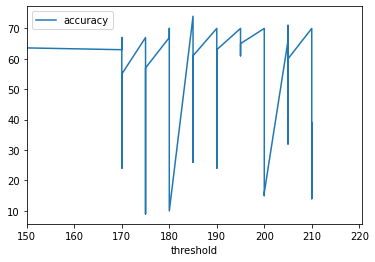

In [48]:
eval_df.plot(x='threshold', y='accuracy', xlim=150);

In [49]:
# Compare contents
filepath = r'notebooks/raw_content/53.txt'
with open(filepath, encoding='utf-8') as f:
    proc_content = f.read().split('\n')

for line_ref, line_ori, line_proc in zip(ref_content, raw_img_content, proc_content):
    print(f'{line_ref:<40}|{line_ori:<40}|{line_proc:<40}')

BIEDRONKA “CODZIENNIE NISKIE CENY“ 4884 |BIEDRONKA “CODZIENNIE NISKIE CENY” 4884 |BIEDRONKA “CODZIENNIE NESKIE CENY” 4884 
02-690 WARSZAWA UL. BOKSERSKA 61        |02-690 WARSZAWA UL, BOKSERSKA 64        |82-690 WARSZAWA UL. BOKSERSKA 64        
JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA S.A.            |JERONIMO MARTINS POLSKA 5.A.            
62-025 KOSTRZYN UL.ŻNIWNA 5             |62-025 KOSTRZYN UL. ZNIHNA 5            |62-025 KOSTRZYN UL. ZNIMNA 5            
                                        |                                        |                                        
NIP 7791011327 nr:185679                |NIP 7794011327 wr 485679                |NIP 7794611327 nr 185679                
PARAGON FISKALNY                        |PARAGON FISKALNY                        |PARAGON FISKALNY                        
PassataSottGus700g D 1 x3,99 3,99D      |PassataSot thus 708g b { x3,99 3,990    |PassataSot tGus/08q b { «3,99 3,990     
Sos Madero 250ml

The best result was obtained with parameters set as following:
- `threshold 185`,
- `sigma_x 1`,
- `sigma_y 1`'.